## Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

## Fu (1981)
```
AET/P = 1 + PET/P - (1 + (PET/P)^w )^1/w
```
Greve et al. 2015:

The free parameter ω in Fu's equation has no a priori physical meaning but is usually interpreted as an integrative property of all catchment and climatic characteristics (e.g., seasonal cycle) other than the prevailing mean climatic conditions (expressed in terms of Ep/P), including vegetation, geographical, topographical, and soil properties. Although no direct estimation of ω is possible for ungauged catchments, Zhang et al. [2004] proposed that ω is larger for forested than for grassland catchments, i.e., E tends to be larger in the former for the same amount of precipitation. We note, however, that recent results suggest a possible different dependence of E on land cover, with higher ET over grassland [Teuling et al., 2010; Williams et al., 2012]. Shao et al. [2012] identified four factors being of major importance for the determination of ω , including the phase difference in the seasonal cycles of P and Ep (related to Milly [1994]). Li et al. [2013] attempted to relate ω to normalized density vegetation index measurements and proposed a linear relationship for large catchments, whereas no relationship is found for small‐ to medium‐sized catchments. Yang et al. [2009] found that the influence of vegetation on the Budyko curve is different under different climate conditions. In a more comprehensive approach, Xu et al. [2013] used a neural network model to assess the influence of vegetation, landscape characteristics, and geolocation influences on ω. However, apart from its universal integrative nature, no definite conclusions about the process controls of ω have been reached up to now.

## Setup constants

In [13]:
np.random.seed(12)
n = 200  # number of points
t = np.arange(n)  # time
quants = np.array([0.05, 0.5, 0.95])  # quantiles
w_avg = 2.6  # vegetation parameter
p_avg = 500  # avg precip
pet_avg = 500  # avg pet
clim_noise = 200  # interannual climate noise
w_noise = 0.2
pet_trend = np.linspace(1, 2*pet_avg, n) + clim_noise*np.random.randn(n)
pet_trend[pet_trend < 0] = .1
pet = pet_avg + clim_noise*np.random.randn(n)
pet[pet < 0] = 0.1
p_trend = np.linspace(2*p_avg, 1, n) + clim_noise*np.random.randn(n)
p_trend[p_trend < 0] = .1
p = p_avg + clim_noise*np.random.randn(n)
p[p < 0] = 0.1
w_trend = np.linspace(1, 2*w_avg, n) + w_noise*np.random.randn(n)
w_trend[w_trend < 1] = 1
w = w_avg + w_noise*np.random.randn(n)
w[w < 1] = 1

## Scenario 1 - increasing temperature (i.e. PET)

In [14]:
p.min()

0.1

In [15]:
pet_1 = pet_trend
p_1 = p
pet_p_1 = pet_1/p_1
aet_p_1 = (1 + (pet_p_1) - ((1 + (pet_p_1)**w)**(1/w)))
q_1 = (1-aet_p_1)*p_1
q_1[q_1 < 0] = 0 

### Quantile regression (scenario 1)

In [16]:
data_1 = pd.DataFrame({'time': t, 'discharge': q_1})
mod_1 = smf.quantreg('discharge~time', data_1)
res_all_1 = [mod_1.fit(q=q) for q in quants]

## Scenario 2 - decreasing precipitation

In [17]:
p_2 = p_trend
pet_2 = pet
pet_p_2 = pet_2/p_2
aet_p_2 = (1 + (pet_p_2) - ((1 + (pet_p_2)**w)**(1/w)))
q_2 = (1-aet_p_2)*p_2
q_2[q_2 < 0] = 0 

### Quantile regression (scenario 2)

In [18]:
data_2 = pd.DataFrame({'time': t, 'discharge': q_2})
mod_2 = smf.quantreg('discharge~time', data_2)
res_all_2 = [mod_2.fit(q=q) for q in quants]

## Scenario 3 - increasing ET

In [30]:
w_3 = w_trend
pet_3 = pet
p_3 = p
pet_p_3 = pet_3/p_3
aet_p_3 = (1 + (pet_p_3) - ((1 + (pet_p_3)**w_3)**(1/w_3)))
q_3 = (1-aet_p_3)*p_3
q_3[q_3 < 0] = 0 

### Quantile regression (scenario 3)

In [31]:
data_3 = pd.DataFrame({'time': t, 'discharge': q_3})
mod_3 = smf.quantreg('discharge~time', data_3)
res_all_3 = [mod_3.fit(q=q) for q in quants]

## Plot results

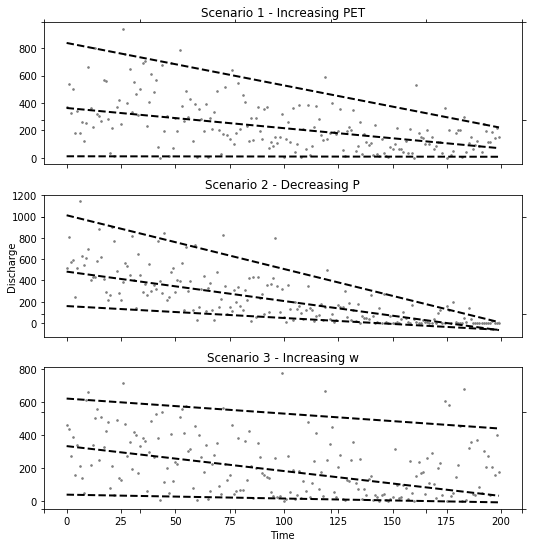

In [33]:
x_p = np.linspace(data_1.time.min(), data_1.time.max(), 50)
df_p = pd.DataFrame({'time': x_p})

fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))

# Setup common axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Time")
plt.ylabel("Discharge")

# Scenario 1 plot
axs[0].scatter(data_1.time, data_1.discharge, color="grey", s=10, marker='.')
axs[0].set_title("Scenario 1 - Increasing PET")
for qm, res in zip(quants, res_all_1):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    axs[0].plot(x_p, res.predict({'time': x_p}), linestyle='--', lw=2, color='k')

# Scenario 2 plot
axs[1].scatter(data_2.time, data_2.discharge, color="grey", s=10, marker='.')
axs[1].set_title("Scenario 2 - Decreasing P")
for qm, res in zip(quants, res_all_2):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    axs[1].plot(x_p, res.predict({'time': x_p}), linestyle='--', lw=2, color='k')

axs[2].scatter(data_3.time, data_3.discharge, color="grey", s=10, marker='.')
axs[2].set_title("Scenario 3 - Increasing w")
for qm, res in zip(quants, res_all_3):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    axs[2].plot(x_p, res.predict({'time': x_p}), linestyle='--', lw=2, color='k')
plt.tight_layout()



In [24]:
w_trend

array([1.        , 1.20438474, 1.21695655, 1.28323221, 1.42818247,
       1.        , 1.        , 1.38638026, 1.34724559, 1.23238617,
       1.        , 1.6209581 , 1.21444944, 1.73458114, 1.39846451,
       1.57645057, 1.        , 1.50449699, 1.2565885 , 1.15716677,
       1.37643225, 2.03694592, 1.36400652, 1.14504304, 1.76050394,
       1.36606811, 1.54941656, 1.92608547, 1.82719864, 1.77303286,
       1.88096902, 1.66079859, 1.43986325, 1.6864412 , 1.63939654,
       1.75249659, 1.75497527, 1.89399654, 2.01085623, 1.71766531,
       1.796421  , 1.93931817, 2.14213491, 1.84768397, 1.53551986,
       2.15742215, 1.71412103, 1.91982531, 1.9232586 , 2.16665587,
       1.69789772, 2.35878782, 2.02792541, 2.37489269, 2.09626501,
       2.76906755, 2.23346613, 2.16101515, 2.10469048, 1.7677146 ,
       2.6335126 , 2.01617135, 2.37587701, 2.52643276, 2.52463906,
       2.38595586, 2.27146686, 2.55995363, 2.43811958, 2.15143685,
       2.29573129, 2.64661341, 2.72535869, 2.05612902, 2.64092